For each SNR level, let's analyse the precision & recall (mono vs beamformed)...

In [2]:
# Some useful functions / imports

import json
from pprint import pprint

def read_results_from_file(file_path):
    """Read the BirdNET detections from a file"""

    with open(file_path, 'r') as file:
        results_dict = json.load(file)

    return results_dict

In [11]:
# First, for a single SNR level------------------------------------------------

expected_species_count = 30         # We should be able to detect 30 calls from each species, per file (3 calls per speaker, over 10 of the 31 speakers in the sphere)

# folder_path = "data/processed/speaker_sphere_lab_tests/0SNR"

# counts_file_path = folder_path + "/species_counts.json"

# counts_dic = read_results_from_file(counts_file_path)

# pprint(counts_dic)

def get_TP_FP_FN(species_count_dict):
    """Calculates the True Positives, True Negatives & False Negatives, from a single processed.json file
    --> Assumes that all Carolina Wren and Eurasian Blackhat detections are correct (as we're expecting them) = TP
    --> Assumes all non-CW and non-EB detections = FP (as weren't expecting other species present)   
    --> Assumes that FN = expected count - TP (i.e., all the missed detections)
    Returns: TP, FP & FN for both channels, in a dictionary"""

    # Initialise dictionary
    P_N_dict = {"mono_channel": {"TP": 0, "FP": 0, "FN": 0},
                "beamformed": {"TP": 0, "FP": 0, "FN": 0}}
    
    for channel in species_count_dict.keys():
        chan_data = species_count_dict[channel]
        # Initialise counts
        TP = 0
        FP = 0
        FN = 0
        for species in chan_data.keys():
            species_count = chan_data[species]
            if species == "Eurasian Blackcap" or species == "Carolina Wren":
                TP += species_count
            else:
                FP += species_count
        FN = expected_species_count*2 - TP          # 2 species expected, thus *2
        
        P_N_dict[channel]["TP"] = TP
        P_N_dict[channel]["FP"] = FP
        P_N_dict[channel]["FN"] = FN
    
    return P_N_dict


def calculate_precision(TP, FP):
    """Returns the precision score, to 3 dp"""

    if (TP+FP) > 0: 
        return round(TP/(TP+FP), 3)
    else:
        return 0


def calculate_recall(TP, FN):
    """Returns the recall rate, to 3 dp"""

    if (TP+FN) > 0: 
        return round(TP/(TP+FN), 3)
    else:
        return 0


def calculate_f1(precision, recall):
    """Returns an f1 score, to 3 dp"""

    if (precision + recall) > 0: 
        return round((2*precision*recall)/(precision+recall), 3)
    else:
        return 0
    

def get_precision_recall_f1(P_N_dict):
    """Calculates the precision, recall rate, and f1 score, for each channel
    Returns: Dictionary with scores, for each channel (and maintains TP, FP & FN)"""
    
    for channel in P_N_dict.keys():
        channel_data = P_N_dict[channel]
        prec = calculate_precision(channel_data["TP"], channel_data["FP"])
        rec = calculate_recall(channel_data["TP"], channel_data["FN"])
        f1 = calculate_f1(prec, rec)
        
        P_N_dict[channel]["precision"] = prec
        P_N_dict[channel]["recall"] = rec
        P_N_dict[channel]["f1"] = f1

    return P_N_dict

# P_N_data = get_TP_FP_FN(counts_dic)
# # pprint(P_N_data)



# prec_rec_data = get_precision_recall_f1(P_N_data)
# pprint(P_N_data)


In [16]:
snr_list = ["n20", "n15", "n10", "n5", "0", "5", "10", "15", "20"]

folder_path = "data/processed/speaker_sphere_lab_tests/"

def extract_prec_rec(SNR_level):
    """For a single species_count.json file, calculate the precision, recall & f1"""

    file_path = folder_path + SNR_level + "SNR/species_counts.json"

    counts_dic = read_results_from_file(file_path)

    P_N_data = get_TP_FP_FN(counts_dic)
    prec_rec_data = get_precision_recall_f1(P_N_data)

    return prec_rec_data

# SNR_prec_rec_data = {}

# for snr in snr_list:
#     SNR_prec_rec_data[snr] = extract_prec_rec(snr)

# pprint(SNR_prec_rec_data)
    

Now lets do some plotting.

Note, we have A LOT of factors...

    -f1 score
    -precision
    -recall
    -SNR
    -confidence threshold  (need to rerun the tests for different confidence levels)
    -mono vs beamformed

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def setup_new_plot(xlabel, ylabel, title):
    """Initialises a new matplotlib plot, with desired parameters"""
    plt.figure(figsize=(18, 12))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)

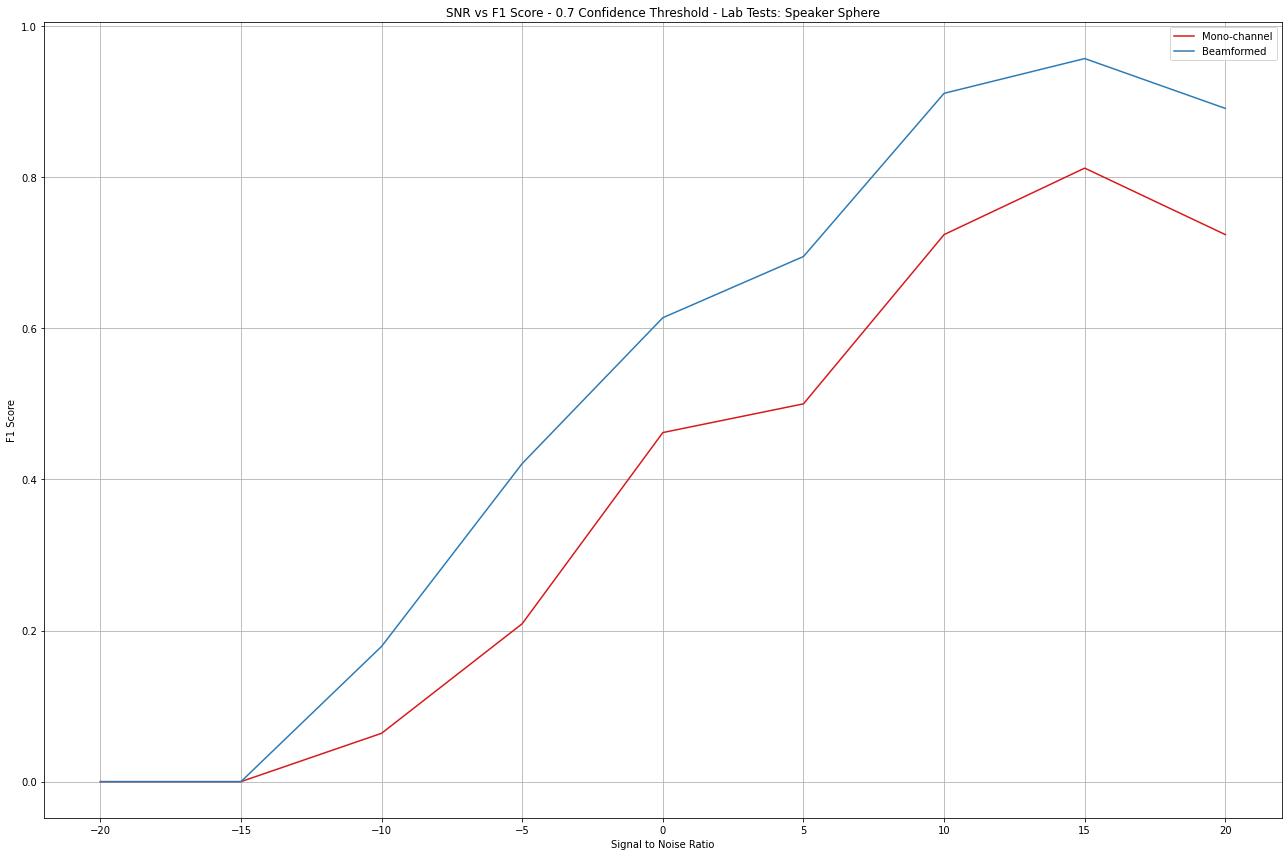

In [21]:
# F1 SCORE vs SNR (0.7 confidence threshold)

setup_new_plot("Signal to Noise Ratio", "F1 Score", "SNR vs F1 Score - 0.7 Confidence Threshold - Lab Tests: Speaker Sphere")

snr_list = ["n20", "n15", "n10", "n5", "0", "5", "10", "15", "20"]

SNR_prec_rec_data = {}

for snr in snr_list:
    SNR_prec_rec_data[snr] = extract_prec_rec(snr)

def get_lists_of_f1(f1_dict):

    mono_f1 = []
    bf_f1 = []

    for snr in snr_list:
        snr_data = f1_dict[snr]
        mono_f1.append(snr_data["mono_channel"]["f1"])
        bf_f1.append(snr_data["beamformed"]["f1"])

    return mono_f1, bf_f1


x_data = np.arange(-20, 21, 5)      # SNR levels

y_mono, y_bf = get_lists_of_f1(SNR_prec_rec_data)

plt.plot(x_data, y_mono, c='#D7191C',)
plt.plot(x_data, y_bf, c='#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Mono-channel')
plt.plot([], c='#2C7BB6', label='Beamformed')
plt.legend()
plt.tight_layout()

plt.show()